# Example of creating a synthetic HI PPV cube

In [1]:
import sys
sys.path.append("../module/") #add path for import
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import tigress_read #scripts for reading data
import yt #https://yt-project.org/

/Users/ckim/miniconda3/envs/packaging/lib/python3.8/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /Users/ckim/.config/yt/ytrc is deprecated in favor of /Users/ckim/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


## Reading data (assuming that you've already downloaded the relevant data)

if not, run this
```
model.download(300,dataset="history")
model.download(300,dataset="input")
model.download(300,dataset="MHD")
```

In [4]:
#master directory of where the data is stored
dir_master = "../data/" #this is default
model_id = "R8_4pc" #name of the simulation model
model = tigress_read.Model(model_id, dir_master=dir_master) #reading the model information

In [5]:
#load the MHD data set for the snapshot ivtk=300
model.load(300, dataset="MHD")

Because we use the python package [YT](https://yt-project.org/) to read the outputs from the MHD simulation, the data stored in the YT format. This means that all fields (such as density, velocity, H2 and CO abundances) in the data has *units* atached. 

Let's convert the YT covering grid into numpy arrray with appropriate units. Also, I take transpose so that the array is in the original C-like ordering `(z,y,x)`

In [7]:
Temp = model.MHD.grid['temperature_init'].in_units("K").value.T
nH = model.MHD.grid['nH'].in_units("cm**-3").value.T
vx = model.MHD.grid['velocity_x'].in_units("km/s").value.T
vy = model.MHD.grid['velocity_y'].in_units("km/s").value.T
vz = model.MHD.grid['velocity_z'].in_units("km/s").value.T

/Users/ckim/miniconda3/envs/packaging/lib/python3.8/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'velocity_y' is ambiguous and corresponds to any one of the following field types:
 {'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "velocity_y")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/ckim/miniconda3/envs/packaging/lib/python3.8/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'velocity_z' is ambiguous and corresponds to any one of the following field types:
 {'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "velocity_z")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


Retrieve cell-centered coordinates for later uses.

In [8]:
xcc, ycc, zcc = model.MHD.grid["x"][:,0,0].to('pc').value, model.MHD.grid["y"][0,:,0].to('pc').value, model.MHD.grid["z"][0,0,:].to('pc').value

/Users/ckim/miniconda3/envs/packaging/lib/python3.8/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'gas', 'athena'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/ckim/miniconda3/envs/packaging/lib/python3.8/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'gas', 'athena'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "y")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/ckim/miniconda3/envs/packaging/lib/python3.8/site-packages/yt/data_objects/

Get cell size in pc and cm for convenience (note that the cell is cubic)

In [9]:
dx_pc = model.MHD.grid['dx'][0,0,0].to('pc').value
dx_cm = model.MHD.grid['dx'][0,0,0].to('cm').value

/Users/ckim/miniconda3/envs/packaging/lib/python3.8/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'dx' is ambiguous and corresponds to any one of the following field types:
 {'gas', 'athena'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "dx")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


## Column density projection (along the y-direction)

In [17]:
plt.rcParams['figure.dpi']=200

In [18]:
# integration along the y-axis (edge on view)
NH = nH.sum(axis=1)*dx_cm

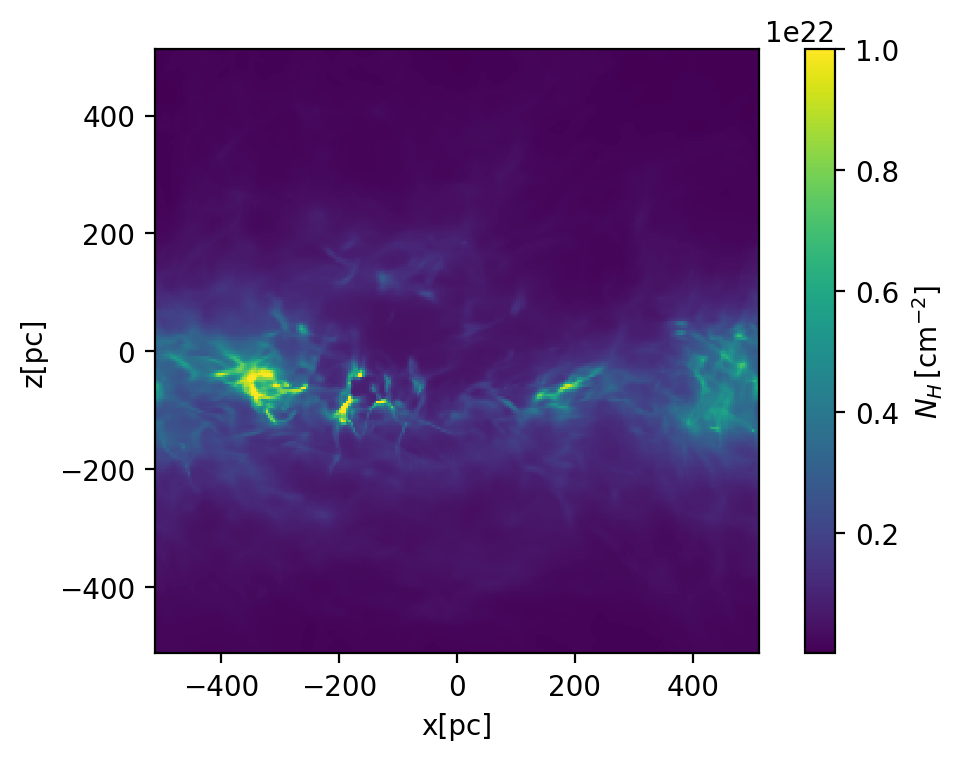

In [19]:
plt.pcolormesh(xcc,zcc,NH,vmax=1.e22,shading='nearest')
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
cbar = plt.colorbar(label=r'$N_H\,[{\rm cm^{-2}}]$')

## Maybe some dense gas is molecular (n>50pcc) 

(-150.0, 0.0)

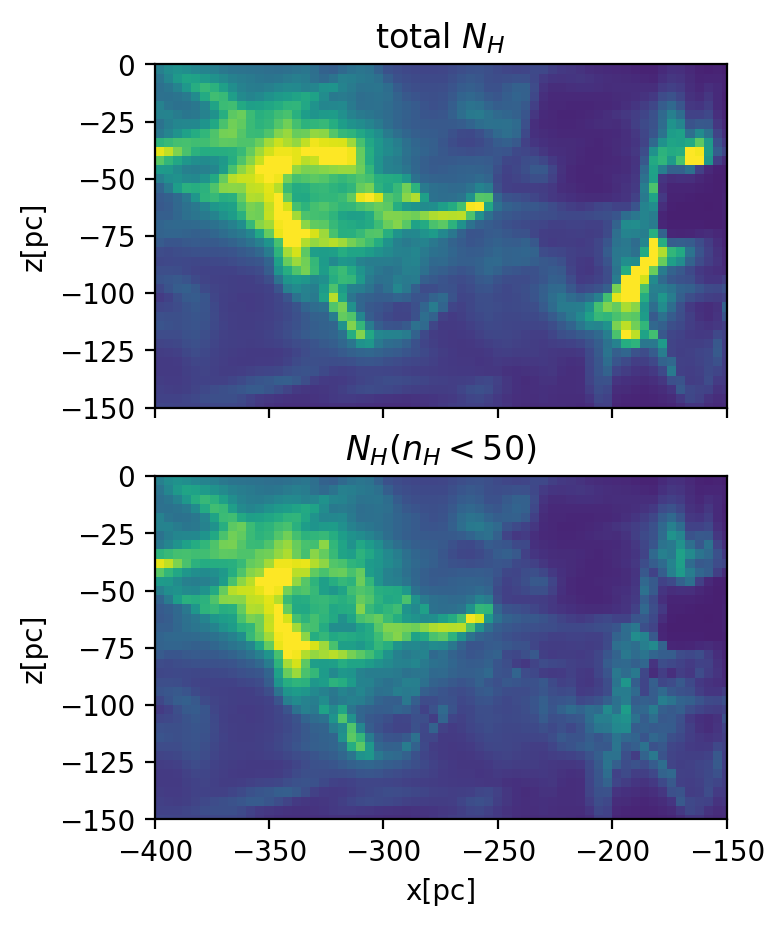

In [28]:
# set threshold density to exclude (assuming that they are molecular)
nth_mol = 50

# integration along the y-axis (edge on view)
NH = nH.sum(axis=1)*dx_cm

# integration along the y-axis excluding molecular gas
nH_masked=nH*(nH<nth_mol) # np.ma.masked_array(nH,mask=nH>nth_mol)
NHI = nH_masked.sum(axis=1)*dx_cm

fig,axes = plt.subplots(2,1,figsize=(5,5),sharex=True,sharey=True)
plt.sca(axes[0])
plt.pcolormesh(xcc,zcc,NH,vmax=1.e22,shading='nearest')
plt.gca().set_aspect('equal')
plt.title('total $N_H$')
# plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
plt.sca(axes[1])
plt.title('$N_H(n_H<50)$')
plt.pcolormesh(xcc,zcc,NHI,vmax=1.e22,shading='nearest')

plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
plt.xlim(-400,-150)
plt.ylim(-150,0)

# Synthetic HI

* Following the method presented in https://ui.adsabs.harvard.edu/abs/2014ApJ...786...64K/abstract
* Assuming that the WF effect is efficient enough to make T_spin = T_k based on Ly alpha radiation transfer study https://ui.adsabs.harvard.edu/abs/2020ApJS..250....9S/abstract
* $$N_H = 1.813\times10^{18}{\rm cm^{-2}}\int T_B \frac{\tau}{1-e^{-\tau}} d(v/(km/s))$$

In [29]:
from synthetic_HI import los_to_HI_axis_proj

In [30]:
help(los_to_HI_axis_proj)

Help on function los_to_HI_axis_proj in module synthetic_HI:

los_to_HI_axis_proj(dens, temp, vel, vchannel, deltas=1.0, los_axis=1)
    inputs:
        dens: number density of hydrogen in units of 1/cm^3
        temp: temperature in units of K
        vel: line-of-sight velocity in units of km/s
        vchannel: velocity channel in km/s
    parameters:
        deltas: length of line segments in units of pc
        memlim: memory limit in GB
        los_axis: 0 -- z, 1 -- y, 2 -- x
    outputs: a dictionary
        TB: the brightness temperature
        tau: optical depth



In [36]:
# this will take some time

vmin,vmax,dv=-50,50,0.5
vch = np.arange(vmin,vmax+0.5*dv,dv) # velocity resolution of 0.5 km/s
nth_mol = 50 # threshold density above which gas is considered as H2
Tth = 1.5e4 # threshold temperature above which gas is considered as HII
nH_masked=nH*((nH<nth_mol) & (Temp<Tth))
TB,tau = los_to_HI_axis_proj(nH_masked,Temp,vy,
                             vch,deltas=dx_pc,
                             los_axis=1, # axis along which the integration is performed (0='z', 1='y', 2='x')
                            )

100%|███████████████████████████████████████████████████| 201/201 [03:21<00:00,  1.00s/it]


In [37]:
TB.shape

(201, 256, 256)

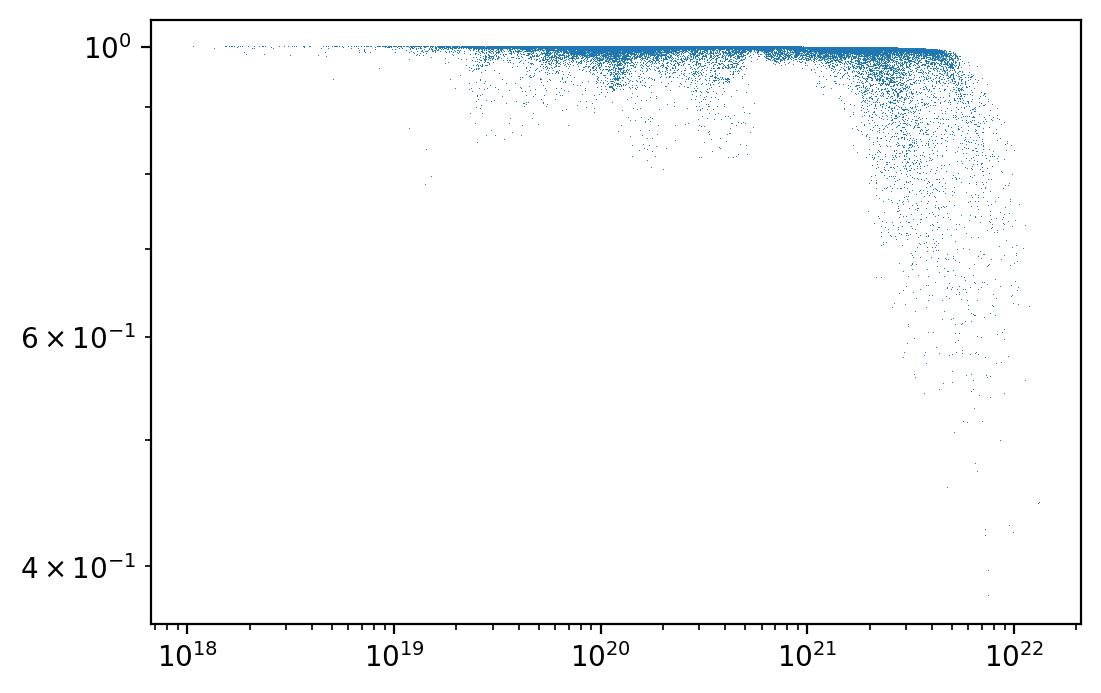

In [38]:
NHI = nH_masked.sum(axis=1)*dx_cm
NHthin = 1.813e18*TB.sum(axis=0)*dv
plt.loglog(NHI.flatten(),NHthin.flatten()/NHI.flatten(),',')

In [39]:
import xarray as xr

In [40]:
TB_da = xr.DataArray(TB,coords=[vch,zcc,xcc],dims=['v','z','x'])

In [41]:
NHthin=1.813e18*dv*TB_da.groupby_bins('v',np.arange(-50,51,10)).sum()

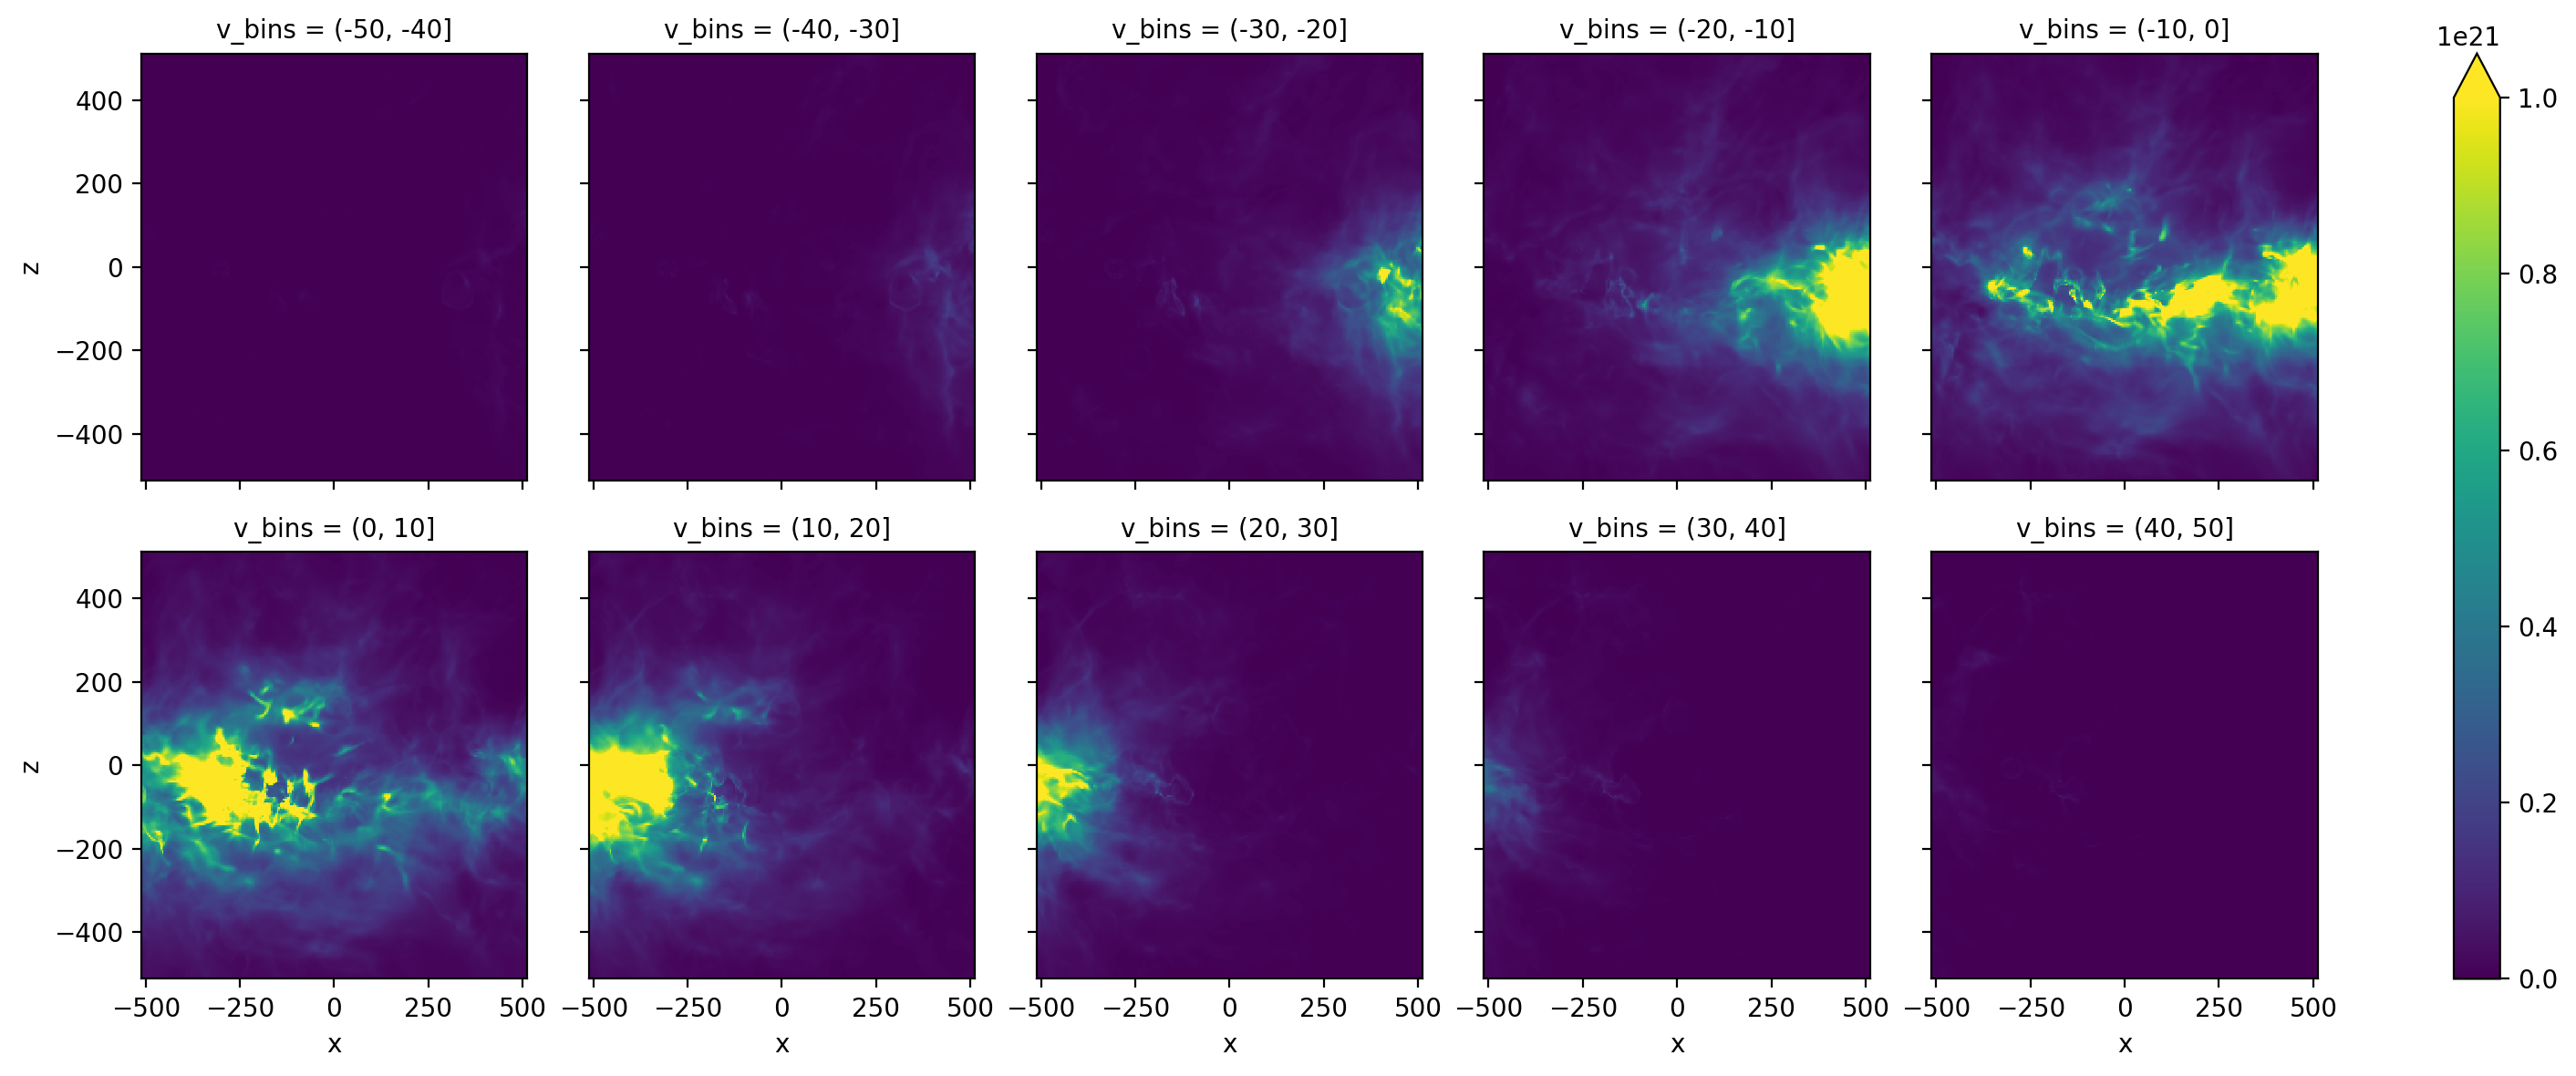

In [42]:
NHthin.plot(col='v_bins',col_wrap=5,vmax=1.e21)

In [43]:
from synthetic_HI import save_to_fits

In [44]:
help(save_to_fits)

Help on function save_to_fits in module synthetic_HI:

save_to_fits(ytds, vchannel, TB, tau, axis='xyv', fitsname=None)
    Function warpper for fits writing
    
    Parameters
    ----------
    ytds: yt.Dataset
        yt Dataset
    vchannel: array
        velocity channel array
    TB: array
        PPV data cube for brightness temperature
    tau: array
        PPV data cube for optical depth
    axis: str
        str for the PPV coordniate names
    fitsname: str
        if not None, fits file is created



In [45]:
hdul=save_to_fits(model.MHD.ytds, vch, TB, tau, axis='xzv', fitsname='test.fits')

FITS file named test.fits is created


In [46]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TIME    =     293.337862012388                                                  
XMIN    =               -512.0 / pc                                             
XMAX    =                512.0 / pc                                             
YMIN    =               -512.0 / pc                                             
YMAX    =                512.0 / pc                                             
ZMIN    =               -512.0 / pc                                             
ZMAX    =                512.0 / pc                                             
DX      =                  4.0 / pc                                             
DY      =                  4